In [1]:
import os
import pandas as pd 
import numpy as np
from lxml import etree 
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200
import os
import glob
import time
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import matplotlib.patches as mpatches
import shutil
from IPython.display import clear_output
pd.set_option('display.max_rows', 500)
from manuf import manuf
from user_agents import parse
import dataframe_image as dfi
import tldextract

In [50]:
iot = pd.read_csv("../tmp_data/inspector2014_with_dist2lib.csv")

In [51]:
iot.sample(1)

,idx,likely_libver,lib_ciphersuites,device_id,cipher_suites,extension_types,tls_version,device_vendor,device_name,cipher_code,ciphersuite_len,cipher_code_idxl,cipher_code_hex,updated_hexcodelis,updated_codelis,likely,likely_idx,likely_score,cumulative_agreement,distance_2lib_sim
2369,39,curl-7.71.073_openssl-1.1.0l,"[49196, 49200, 159, 52393, 52392, 52394, 49195, 49199, 158, 49188, 49192, 107, 49187, 49191, 103, 49162, 49172, 57, 49161, 49171, 51, 157, 156, 61, 60, 53, 47, 255]",s62f8c5b229,49195+49196+49199+49200+49171+49172+156+157+47+53+255,11+10+35+13+16,771,amazon,fire,"[49195, 49196, 49199, 49200, 49171, 49172, 156, 157, 47, 53, 255]",11,"['49195:0', '49196:1', '49199:2', '49200:3', '49171:4', '49172:5', '156:6', '157:7', '47:8', '53:9', '255:10']","['0xc02b', '0xc02c', '0xc02f', '0xc030', '0xc013', '0xc014', '0x9c', '0x9d', '0x2f', '0x35', '0xff']","['0xc02b', '0xc02c', '0xc02f', '0xc030', '0xc013', '0xc014', '0x9c', '0x9d', '0x2f', '0x35', '0xff']","[49195, 49196, 49199, 49200, 49171, 49172, 156, 157, 47, 53, 255]","[39, 0.3793103448275862]",39,0.37931,"[0.0, 0.5, 0.3333333333333333, 0.5, 0.4, 0.3333333333333333, 0.42857142857142855, 0.5, 0.4444444444444444, 0.4, 0.36363636363636365, 0.3333333333333333, 0.32, 0.3076923076923077, 0.296296296296296...",3


In [52]:
iot.shape

(5827, 20)

In [23]:
iot['updated_codelis'] = iot['updated_codelis'].apply(lambda x: eval(x))

In [24]:
cipher_map = pd.read_csv("../ciphersuite_map.csv")

In [25]:
cipher_map.sample(2)

,ciphersuite,count,code_1sthalf,code_2ndhalf,code,cipher_y,dtls_ok,recommended,ref,key_exchange,mac,cipher,code_base10
258,0xe,3,0x00,0x0e,"0x00,0x0e",TLS_DH_RSA_EXPORT_WITH_DES40_CBC_SHA,Y,N,[RFC4346],tls_dh_rsa,sha,des40_cbc,14
32,0x6b,2077,0x00,0x6b,"0x00,0x6b",TLS_DHE_RSA_WITH_AES_256_CBC_SHA256,Y,N,[RFC5246],tls_dhe_rsa,sha256,aes_256_cbc,107


In [26]:
def finding_vul_components(df):
    ret_lis = []
    if "anon" in df['key_exchange']:
        ret_lis.append("anon")
    if "export" in df['key_exchange']:
        ret_lis.append("export")
    if "no_cipher" in df['cipher']:
        ret_lis.append("no_cipher")
    if ("rc2" in df['cipher']) or ("rc4" in df['cipher']):
        ret_lis.append("rc")
    if ("des" in df['cipher']) and ("3des" not in df['cipher']):
        ret_lis.append("des")
    if "3des" in df['cipher']:
        ret_lis.append("3des")
    if not ret_lis:
        return "none"
    else:
        return ",".join(ret_lis)

In [27]:
cipher_map['vul_components'] = cipher_map.apply(lambda x: finding_vul_components(x), axis=1)

In [28]:
cipher_map.sample(5)

,ciphersuite,count,code_1sthalf,code_2ndhalf,code,cipher_y,dtls_ok,recommended,ref,key_exchange,mac,cipher,code_base10,vul_components
121,0xc0a3,89,0xc0,0xa3,"0xc0,0xa3",TLS_DHE_RSA_WITH_AES_256_CCM_8,N,N,[RFC6655],tls_dhe_rsa,sha256,aes_256_ccm_8,49315,none
0,0x2f,10580,0x00,0x2f,"0x00,0x2f",TLS_RSA_WITH_AES_128_CBC_SHA,Y,N,[RFC5246],tls_rsa,sha,aes_128_cbc,47,none
77,0x10,1292,0x00,0x10,"0x00,0x10",TLS_DH_RSA_WITH_3DES_EDE_CBC_SHA,Y,N,[RFC5246],tls_dh_rsa,sha,3des_ede_cbc,16,3des
5,0xc013,8015,0xc0,0x13,"0xc0,0x13",TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA,Y,N,[RFC8422],tls_dhe_rsa,sha,aes_128_cbc,49171,none
296,0xc049,2,0xc0,0x49,"0xc0,0x49",TLS_ECDHE_ECDSA_WITH_ARIA_256_CBC_SHA384,Y,N,[RFC6209],tls_ecdhe_ecdsa,sha384,aria_256_cbc,49225,none


In [29]:
vul_cipher_map = cipher_map.loc[cipher_map['vul_components'] != "none"][['ciphersuite', 'code', 'code_base10', \
                                                                         'cipher_y', 'key_exchange', 'mac', 'cipher', \
                                                                         'vul_components']]

In [30]:
vul_cipher_map.to_csv("../tmp_data/vul_component_connectivity.csv", index=False)

In [31]:
cipher_map['cipher'].value_counts()

aes_256_cbc          32
aes_128_cbc          32
camellia_256_cbc     20
no_cipher            20
3des_ede_cbc         20
camellia_128_cbc     20
rc4_128              14
aria_128_cbc         14
aes_256_gcm          14
aria_256_cbc         14
aes_128_gcm          14
camellia_256_gcm     13
aria_128_gcm         13
camellia_128_gcm     13
aria_256_gcm         13
chacha20_poly1305    10
des_cbc               8
seed_cbc              6
des40_cbc             6
aes_128_ccm_8         6
aes_128_ccm           6
aes_256_ccm_8         5
aes_256_ccm           5
rc4_40                4
idea_cbc              3
rc2_cbc_40            3
des_cbc_40            2
secure_renego         1
fallback_scsv         1
Name: cipher, dtype: int64

In [7]:
#broken_lis = ['dh_anon', 'krb5_export', 'ecdh_anon', 'rc4_128', 'rc4_40', \
#              'rc2_cbc_40', 'des_cbc', 'des40_cbc', 'des_cbc_40']

In [32]:
cipher_map['if_anon'] = cipher_map['key_exchange'].apply(lambda x: 1 if "anon" in x else 0)
cipher_map['if_export'] = cipher_map['key_exchange'].apply(lambda x: 1 if "export" in x else 0)
#cipher_map['if_null'] = cipher_map['key_exchange'].apply(lambda x: 1 if "null" in x else 0)
cipher_map['if_rc4'] = cipher_map['cipher'].apply(lambda x: 1 if "rc4" in x else 0)
cipher_map['if_rc2'] = cipher_map['cipher'].apply(lambda x: 1 if "rc2" in x else 0)
cipher_map['if_des'] = cipher_map['cipher'].apply(lambda x: 1 if ("des" in x and "3des" not in x) else 0)
cipher_map['if_3des'] = cipher_map['cipher'].apply(lambda x: 1 if "3des" in x else 0)
cipher_map['if_nocipher'] = cipher_map['cipher'].apply(lambda x: 1 if "no_cipher" in x else 0)
#cipher_map['if_md5'] = cipher_map['mac'].apply(lambda x: 1 if "md5" in x else 0)
#cipher_map['if_sha'] = cipher_map['mac'].apply(lambda x: 1 if x == "sha" else 0)

In [33]:
cipher_map.sample(1)

,ciphersuite,count,code_1sthalf,code_2ndhalf,code,cipher_y,dtls_ok,recommended,ref,key_exchange,mac,cipher,code_base10,vul_components,if_anon,if_export,if_rc4,if_rc2,if_des,if_3des,if_nocipher
58,0x84,1445,0x00,0x84,"0x00,0x84",TLS_RSA_WITH_CAMELLIA_256_CBC_SHA,Y,N,[RFC5932],tls_rsa,sha,camellia_256_cbc,132,none,0,0,0,0,0,0,0


In [34]:
iot_exp = iot.explode('updated_codelis')

In [35]:
iot_exp['updated_codelis'] = iot_exp['updated_codelis'].apply(lambda x: int(x))

In [36]:
merge = pd.merge(iot_exp, cipher_map, left_on='updated_codelis', right_on='code_base10', how='inner')

In [37]:
merge.sample(1)

,idx,likely_libver,lib_ciphersuites,device_id,cipher_suites,extension_types,tls_version,device_vendor,device_name,cipher_code,ciphersuite_len,cipher_code_idxl,cipher_code_hex,updated_hexcodelis,updated_codelis,likely,likely_idx,likely_score,cumulative_agreement,distance_2lib_sim,ciphersuite,count,code_1sthalf,code_2ndhalf,code,cipher_y,dtls_ok,recommended,ref,key_exchange,mac,cipher,code_base10,vul_components,if_anon,if_export,if_rc4,if_rc2,if_des,if_3des,if_nocipher
20474,24,curl-7.34.060_openssl-1.0.2f,"[49200, 49196, 49192, 49188, 49172, 49162, 165, 163, 161, 159, 107, 106, 105, 104, 57, 56, 55, 54, 136, 135, 134, 133, 49202, 49198, 49194, 49190, 49167, 49157, 157, 61, 53, 132, 49199, 49195, 491...",s87e9e4ade4,49200+49196+49192+49188+49172+49162+165+163+161+159+107+106+105+104+57+56+55+54+136+135+134+133+49202+49198+49194+49190+49167+49157+157+61+53+132+49199+49195+49191+49187+49171+49161+164+162+160+15...,11+10+35+13+15,771,amazon,echo,"[49200, 49196, 49192, 49188, 49172, 49162, 165, 163, 161, 159, 107, 106, 105, 104, 57, 56, 55, 54, 136, 135, 134, 133, 49202, 49198, 49194, 49190, 49167, 49157, 157, 61, 53, 132, 49199, 49195, 491...",91,"['49200:0', '49196:1', '49192:2', '49188:3', '49172:4', '49162:5', '165:6', '163:7', '161:8', '159:9', '107:10', '106:11', '105:12', '104:13', '57:14', '56:15', '55:16', '54:17', '136:18', '135:19...","['0xc030', '0xc02c', '0xc028', '0xc024', '0xc014', '0xc00a', '0xa5', '0xa3', '0xa1', '0x9f', '0x6b', '0x6a', '0x69', '0x68', '0x39', '0x38', '0x37', '0x36', '0x88', '0x87', '0x86', '0x85', '0xc032...","['0xc030', '0xc02c', '0xc028', '0xc024', '0xc014', '0xc00a', '0xa5', '0xa3', '0xa1', '0x9f', '0x6b', '0x6a', '0x69', '0x68', '0x39', '0x38', '0x37', '0x36', '0x88', '0x87', '0x86', '0x85', '0xc032...",158,"[24, 1.0]",24,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,0x9e,3234,0x00,0x9e,"0x00,0x9e",TLS_DHE_RSA_WITH_AES_128_GCM_SHA256,Y,Y,[RFC5288],tls_dhe_rsa,sha256,aes_128_gcm,158,none,0,0,0,0,0,0,0


In [38]:
merge.loc[merge['if_nocipher'] == 1].groupby(['device_id', 'device_vendor'])['idx'].agg('count').reset_index()

,device_id,device_vendor,idx
0,s013982cb33,tplink,23
1,s21477137f7,western digital,23
2,s7a500db658,synology,24
3,sae3084a8ef,synology,23
4,sd1724bbe72,synology,58


In [39]:
merge.loc[merge['if_export'] == 1].groupby(['device_id', 'device_vendor'])['idx'].agg('count').reset_index()

,device_id,device_vendor,idx
0,sd1724bbe72,synology,14


In [40]:
merge.loc[merge['if_anon'] == 1].groupby(['device_id', 'device_vendor'])['idx'].agg('count').reset_index()

,device_id,device_vendor,idx
0,s013982cb33,tplink,53
1,s0746560305,sony,4
2,s0774d7a615,amazon,10
3,s13f791d96d,hp,6
4,s16947200b8,sony,4
5,s17eba45c99,synology,11
6,s19d004be73,hp,2
7,s1a5803e798,hp,2
8,s1bcafb6637,amazon,10
9,s1dcaaa999a,philips,3


In [43]:
merge_sub = merge[['idx', 'likely_libver', 'distance_2lib_sim', 'device_id', 'device_vendor', 'device_name', \
                   'cipher_code', 'updated_codelis', 'if_anon', 'if_export', \
                   'if_rc4', 'if_rc2', 'if_des', 'if_3des', 'if_nocipher']]

In [44]:
merge_sub.sample(1)

,idx,likely_libver,distance_2lib_sim,device_id,device_vendor,device_name,cipher_code,updated_codelis,if_anon,if_export,if_rc4,if_rc2,if_des,if_3des,if_nocipher
95601,38,curl-7.71.068_openssl-1.0.2u,3,sba8d3874fc,roku,media,"[49200, 49196, 49192, 49188, 49172, 49162, 165, 163, 161, 159, 107, 106, 105, 104, 57, 56, 55, 54, 136, 135, 134, 133, 49202, 49198, 49194, 49190, 49167, 49157, 157, 61, 53, 132, 49199, 49195, 491...",49191,0,0,0,0,0,0,0


In [45]:
merge_gb = merge_sub.groupby(['idx', 'likely_libver', 'distance_2lib_sim', 'device_id', \
                              'device_vendor', 'device_name', 'cipher_code'])\
                    .agg({'if_anon':'sum', 'if_export':'sum', 'if_rc4':'sum', \
                         'if_rc2':'sum', 'if_des':'sum', 'if_3des':'sum', 'if_nocipher':'sum'}).reset_index()

In [46]:
merge_gb['if_anon'] = merge_gb['if_anon'].apply(lambda x: 1 if x >= 1 else 0)
merge_gb['if_export'] = merge_gb['if_export'].apply(lambda x: 1 if x >= 1 else 0)
#merge_gb['if_null'] = merge_gb['if_null'].apply(lambda x: 1 if x >= 1 else 0)
merge_gb['if_rc4'] = merge_gb['if_rc4'].apply(lambda x: 1 if x >= 1 else 0)
merge_gb['if_rc2'] = merge_gb['if_rc2'].apply(lambda x: 1 if x >= 1 else 0)
merge_gb['if_des'] = merge_gb['if_des'].apply(lambda x: 1 if x >= 1 else 0)
merge_gb['if_3des'] = merge_gb['if_3des'].apply(lambda x: 1 if x >= 1 else 0)
merge_gb['if_nocipher'] = merge_gb['if_nocipher'].apply(lambda x: 1 if x >= 1 else 0)
#merge_gb['if_md5'] = merge_gb['if_md5'].apply(lambda x: 1 if x >= 1 else 0)
#merge_gb['if_sha'] = merge_gb['if_sha'].apply(lambda x: 1 if x >= 1 else 0)

In [47]:
merge_gb.sample(1)

,idx,likely_libver,distance_2lib_sim,device_id,device_vendor,device_name,cipher_code,if_anon,if_export,if_rc4,if_rc2,if_des,if_3des,if_nocipher
3382,39,curl-7.71.073_openssl-1.1.0l,3,saf83370dfd,amazon,fire,"[49195, 49196, 49199, 49200, 49171, 49172, 156, 157, 47, 53, 255]",0,0,0,0,0,0,0


In [48]:
merge_gb.shape

(5825, 14)

In [49]:
merge_gb.to_csv("../tmp_data/inspector_wihtvul.csv", index=False)

In [317]:
vendor_cnt = merge_dropdup.groupby(['device_vendor'])['cipher_code'].agg('count').reset_index(name='total')

In [318]:
broken = merge_dropdup.groupby(['device_vendor']).agg({'if_anon':'sum', 'if_export':'sum', \
                                                       'if_rc4':'sum', 'if_rc2':'sum', 'if_des':'sum', \
                                                       'if_nocipher':'sum', 'if_3des':'sum'})\
                                                 .reset_index()

In [319]:
broken_merge = pd.merge(vendor_cnt, broken, how='inner', left_on='device_vendor', right_on='device_vendor')

In [320]:
broken_merge['perc_anon'] = broken_merge['if_anon'] / broken_merge['total'] 
broken_merge['perc_export'] = broken_merge['if_export'] / broken_merge['total'] 
#broken_merge['perc_null'] = broken_merge['if_null'] / broken_merge['total'] 
broken_merge['perc_rc4'] = broken_merge['if_rc4'] / broken_merge['total'] 
broken_merge['perc_rc2'] = broken_merge['if_rc2'] / broken_merge['total'] 
broken_merge['perc_des'] = broken_merge['if_des'] / broken_merge['total']
broken_merge['perc_3des'] = broken_merge['if_3des'] / broken_merge['total'] 
broken_merge['perc_nocipher'] = broken_merge['if_nocipher'] / broken_merge['total'] 
#broken_merge['perc_md5'] = broken_merge['if_md5'] / broken_merge['total'] 
#broken_merge['perc_sha'] = broken_merge['if_sha'] / broken_merge['total'] 

In [348]:
broken_fig = broken_merge[['device_vendor', 'perc_anon', 'perc_export', 'perc_rc4', 'perc_rc2', \
                           'perc_des', 'perc_nocipher', 'perc_3des']]

In [349]:
broken_fig = broken_fig.loc[broken_fig['device_vendor'] != 'unknown']

In [350]:
broken_fig['device_vendor'] = broken_fig['device_vendor'].apply(lambda x: x.capitalize())

In [351]:
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Lg')] = 'LG'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Directv')] = 'DirecTV'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Dish network')] = 'Dish Network'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Tcl')] = 'TCL'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Tplink')] = 'TP-Link'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Western digital')] = 'Western Digital'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Hp')] = 'HP'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Ihome')] = 'iHome'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Ikea')] = 'IKEA'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Irobot')] = 'iRobot'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Netgear')] = 'NETGEAR'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Qnap')] = 'QNAP'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Sleep number')] = 'Sleep Number'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Echobee')] = 'echobee'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Idevices')] = 'iDevices'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Vmware')] = 'VMware'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Hdhomerun')] = 'HDHomeRun'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Ecobee')] = 'ecobee'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Texas instruments')] = 'Texas Instruments'
broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Ubiquity')] = 'Ubiquiti'

<ipython-input-351-6c4d7048ea98>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Lg')] = 'LG'
<ipython-input-351-6c4d7048ea98>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  broken_fig.device_vendor[broken_fig['device_vendor'].str.contains('Directv')] = 'DirecTV'
<ipython-input-351-6c4d7048ea98>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  broken_fig.device_vendo

In [352]:
broken_fig.sample(1)

,device_vendor,perc_anon,perc_export,perc_rc4,perc_rc2,perc_des,perc_nocipher,perc_3des
18,Humax,0.0,0.0,0.0,0.0,0.0,0.0,0.666667


In [353]:
broken_fig = broken_fig.rename({'perc_anon': 'Anonymous key exchange', \
                                'perc_export': 'Export-grade cipher', \
                                'perc_nocipher': 'NULL encryption', \
                                'perc_rc2': 'RC2', \
                                'perc_rc4': 'RC4', \
                                'perc_des': 'DES', \
                                'perc_3des': '3DES'}, axis=1)

In [354]:
broken_fig_sum = broken_fig.copy()

In [355]:
broken_fig_sum['sum'] = broken_fig_sum.sum(axis=1)

In [356]:
vendor_lis = broken_fig_sum.sort_values(by='sum', ascending=False)['device_vendor'].tolist()

In [366]:
alg_lis = ['Anonymous key exchange', 'NULL encryption', 'Export-grade cipher', \
           'RC2', 'RC4', 'DES', '3DES']

In [358]:
broken_fig = broken_fig.set_index('device_vendor')

### Plot

In [367]:
broken_fig_sort = broken_fig.reindex(vendor_lis)

In [368]:
broken_fig_try = broken_fig_sort.T.copy()

In [369]:
broken_fig_try = broken_fig_try.reindex(alg_lis)

In [370]:
mask = np.zeros_like(broken_fig_try)

In [371]:
broken_fig_mask = (broken_fig_try == 0).values

In [372]:
#broken_fig_mask

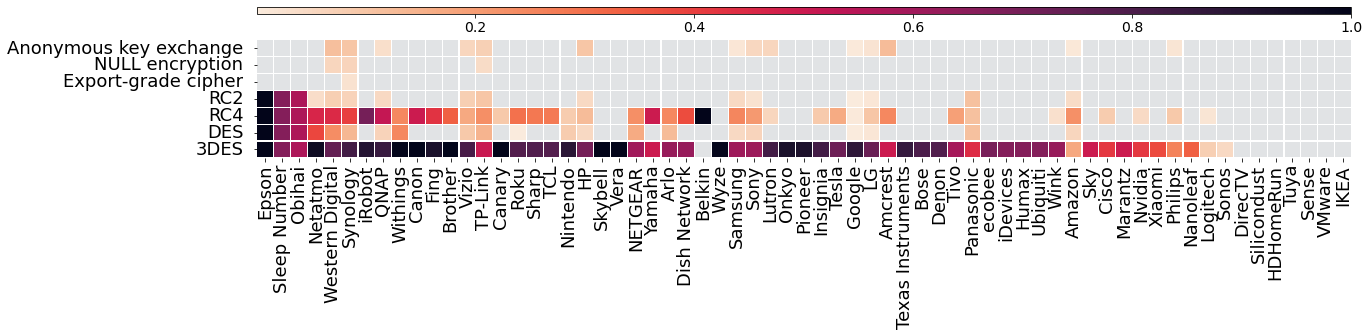

In [381]:
#fig = plt.figure(figsize=(18, 9))
#cbar_kws={"shrink": .5, "orientation": "horizontal"},

fig, (cax, ax) = plt.subplots(nrows=2, figsize=(19, 4.5), gridspec_kw={"height_ratios":[0.05, 1]})
ax = sns.heatmap(broken_fig_try, cmap="rocket_r", ax=ax, square=True, cbar=False, linecolor='white', \
                 mask = broken_fig_mask, linewidths=.1)

cbar = fig.colorbar(ax.get_children()[0], cax=cax, orientation="horizontal")
cbar.ax.tick_params(labelsize=14) 


ax.set_facecolor("#E1E3E5")
#ax.set_facecolor(((0.0, 0.0, 0.0, 0.3)))

#fig.colorbar(ax.get_children()[0], cax=cax, fraction=0.046, pad=0.04, orientation="horizontal")

plt.ylabel("")
plt.xlabel("")
    
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18, ha='center', va='top')
ax.tick_params(axis="y",direction="out", pad=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18, va='center')

#fig.tight_layout()
plt.subplots_adjust(left=0.19, right=0.99, bottom=0.49, top=0.99)
fig.savefig("../figures/ciphersuite_vulnerability.png", dpi=150)

plt.show()

### TLS_FALLBACK_SCSV

In [386]:
cipher_map.loc[cipher_map['cipher_y'] == 'TLS_FALLBACK_SCSV']

,ciphersuite,count,code_1sthalf,code_2ndhalf,code,cipher_y,dtls_ok,recommended,ref,key_exchange,mac,cipher,code_base10,if_anon,if_export,if_rc4,if_rc2,if_des,if_3des,if_nocipher
210,0x5600,27,0x56,0x00,"0x56,0x00",TLS_FALLBACK_SCSV,Y,N,[RFC7507],tls_fallback,scsv,fallback_scsv,22016,0,0,0,0,0,0,0


In [395]:
def is_22016(lis):
    if 22016 in lis:
        return True
    else:
        False

In [396]:
iot['is_22016'] = iot['updated_codelis'].apply(lambda x: is_22016(x))

In [398]:
iot.loc[iot['is_22016'] == True].groupby(['device_vendor'])['device_id'].agg(lambda x: x.nunique())\
                                .reset_index(name='count')

,device_vendor,count
0,amazon,15
1,cisco,1
2,philips,1
3,samsung,1
4,synology,1
5,tivo,1
